### Inference: How to generate novel attribute compositions, ones the model is trained
For training documentation follow README.md

In [1]:
#typically for load model from the config but its okay we will define the config as a dict
import sys
import os
parent_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(parent_dir)

import torch
import pytorch_lightning as pl
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from matplotlib import cm
from typing import Optional
import functools
import seaborn as sns
import math
import hydra
from diffusers import DDPMScheduler,AutoencoderKL,UNet2DModel

from coind.models.conditional_unet import ClassConditionalUnet
from coind.score.pipelines import CondDDIMPipeline
from utils import save_images,make_grid

torch.manual_seed(42)
if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use GPU 1
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


In [2]:
model_config = {
    '_target_': ClassConditionalUnet,
    'num_class_per_label': [2,2],
    'interaction': 'sum',
    'sample_size': 8,
    'in_channels': 16,
    'out_channels': 16, 
    'center_input_sample': False,
    'time_embedding_type': 'positional'
}
scheduler_config = {
    '_target_': DDPMScheduler,
    'num_train_timesteps': 1000,
    'beta_start': 0.0001,
    'beta_end': 0.02,
    'beta_schedule': 'linear',
}

In [3]:
model = hydra.utils.instantiate(model_config).to(device)
scheduler = hydra.utils.instantiate(scheduler_config)

#load model
checkpoint_path = '/research/hal-gaudisac/Diffusion/compositional-generation/outputs/2025-01-29/12-52-01/tensorboard/version_0/checkpoints/s.ckpt'
model_state_dict = {k.replace('model.',''): v for k, v in torch.load(checkpoint_path)['state_dict'].items() if k.startswith('model.')}
model.load_state_dict(model_state_dict, strict=False)

#load vae
vae = AutoencoderKL.from_pretrained('stabilityai/stable-diffusion-3-medium-diffusers', subfolder='vae', cache_dir='checkpoints')
vae = vae.to(device)

/tmp/ipykernel_714685/1928895259.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = {k.replace('model.',''): v for k, v in torch.load(checkpoint_path)['s

In [4]:
class ModelWrapper(UNet2DModel):
    def __init__(self, model):
        super().__init__()
        self.model = model
    @torch.no_grad()
    def forward(self, x, t, y):
        raise NotImplementedError
    #config should be same as the model
    @property
    def config(self):
        return self.model.config

class ANDquery(ModelWrapper):

    def forward(self, x, t, y, **kwargs):
        # query, guidance_scale, null_token
        
        if 'null_token' not in kwargs:
            raise ValueError('null_token is not provided')    
        
        null_token = kwargs['null_token']
        query = self.prepare_and_query(y,null_token)
        B,Q,D = query.size()

        if 'guidance_scale' in kwargs:
            if isinstance(kwargs['guidance_scale'], float):
                guidance_scale = [kwargs['guidance_scale']]*Q
            else:
                guidance_scale = kwargs['guidance_scale']
        else:
            guidance_scale = [7.5]*Q

        model_in = torch.cat([x]*(Q+1), 0)
        query = query.transpose(1, 0).reshape(B*Q, D)
        query = torch.cat([null_token, query], 0)
        model_output = self.model(model_in, t, query)
        chunk_model_output = model_output.chunk(Q+1, dim=0)
        model_output = chunk_model_output[0] + sum([guidance_scale[i]*(chunk_model_output[i+1] - chunk_model_output[0]) for i in range(Q)])
        return model_output
    def prepare_and_query(self,y,null_token):
        B,Q = y.size()
        query = null_token.repeat(Q,1).to(dtype=y.dtype,device=y.device)
        query = query.reshape(B,Q,Q)
        for i in range(Q):
            query[:,i,i] = y[:,i]
        return query

class CFGquery(ModelWrapper):

    def forward(self, x, t, y, **kwargs):
        # query, guidance_scale, null_token
        
        if 'null_token' not in kwargs:
            raise ValueError('null_token is not provided')    
        
        null_token = kwargs['null_token']

        guidance_scale = kwargs.get('guidance_scale', 7.5)

        model_in = torch.cat([x]*(2), 0)
        query = torch.cat([null_token, y], 0)
        model_output = self.model(model_in, t, query)
        chunk_model_output = model_output.chunk(2, dim=0)
        model_output = chunk_model_output[0] + guidance_scale*(chunk_model_output[1] - chunk_model_output[0])
        return model_output
    def prepare_and_query(self,y,null_token):
        B,Q = y.size()
        query = null_token.repeat(Q,1).to(dtype=y.dtype,device=y.device)
        query = query.reshape(B,Q,Q)
        for i in range(Q):
            query[:,i,i] = y[:,i]
        return query

and_model = ANDquery(model).to(device)
cfg_model = CFGquery(model).to(device)
pipeline = CondDDIMPipeline(and_model,scheduler=scheduler,vae = vae)

Dropdown(description='Gender:', options=('Male', 'Female'), value='Male')

Dropdown(description='Blond:', options=('Blond', 'Non-Blond'), value='Blond')

IntSlider(value=7, description='Gender Control:', max=21, min=1)

IntSlider(value=7, description='Blond Control:', max=21, min=1)

Button(description='Run', style=ButtonStyle())

Output()

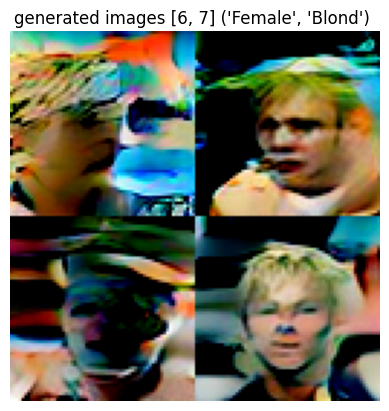

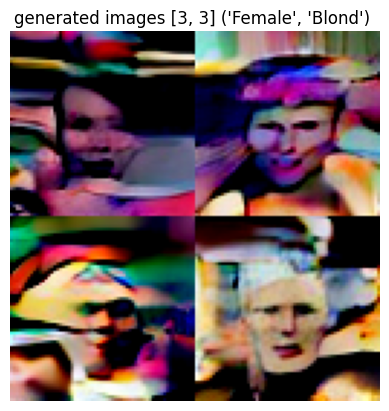

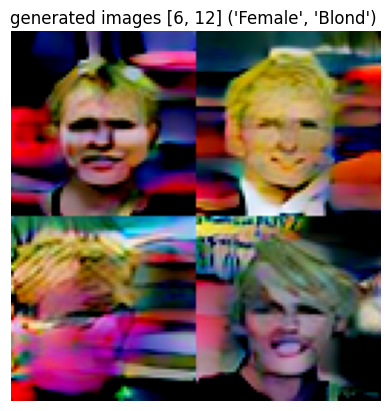

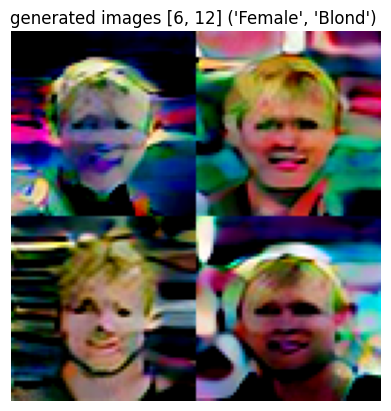

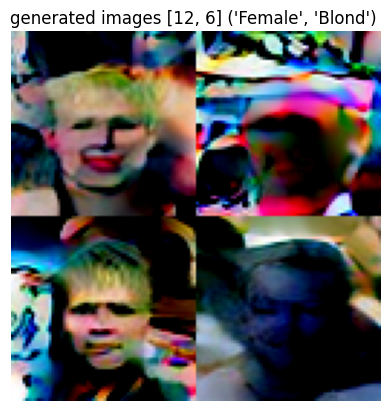

In [6]:
import ipywidgets as widgets
from IPython.display import display
gender_dropdown = widgets.Dropdown(options=['Male', 'Female'], description='Gender:')
blond_dropdown = widgets.Dropdown(options=['Blond', 'Non-Blond'], description='Blond:')

gender_slider = widgets.IntSlider(description='Gender Control:', min=1, max=21, value=7.0)
blond_slider = widgets.IntSlider(description='Blond Control:', min=1, max=21, value=7.0)


#number of images

button = widgets.Button(description="Run")
output = widgets.Output()

display(gender_dropdown, blond_dropdown,gender_slider,blond_slider,button, output)


def on_button_click(b):
    with output:
        output.clear_output()
        num_of_images = 4
        gender = int(gender_dropdown.value == 'Male')
        blond = int(blond_dropdown.value =="Blond")
        query =  torch.tensor([[gender, blond]]*num_of_images).to(device)
        guidance_scale = [gender_slider.value,blond_slider.value]
        null_token = torch.ones_like(query).to(device)*2
        num_inference_steps = 300
        generated_images = pipeline(batch_size=query.size(0), 
                        num_inference_steps= num_inference_steps,
                        return_dict= True,
                        use_clipped_model_output = True,
                        query = query,
                        guidance_scale=guidance_scale,
                        null_token=null_token)[0]
        generated_images = generated_images.cpu().detach()
        fig,ax= plt.subplots()
        ax = save_images(generated_images,ax,f'generated images {guidance_scale} {(gender_dropdown.value,blond_dropdown.value)} ')
        fig.show()
button.on_click(on_button_click)